# The Story of COVID-19 in India

#### The COVID-19 pandemic is the defining global health crisis of our time and the greatest global humanitarian challenge the world has faced since World War II. The virus has spread widely, and the number of cases is rising daily as governments work to slow its spread. India has moved quickly, implementing a proactive, nationwide, lockdown, with the goal of flattening the curve and using the time to plan and resource responses adequately.

![](https://i.imgur.com/HdKy1CA.png)

# Table of Contents

* [World Updates](#32)
* [India Updates](#1)
* [Age Group/Gender Analysis](#2)
* [The Spike in India](#3)
* [Testing in India](#8)
* [Statewise Insights](#5)
* [Statewise Testing and Healthcare Insights](#6)
* [Economic Impact of COVID-19 on India](#4)
* [Prediction](#7)
     * [Growth Factor](#9)
     * [Prophet Model](#10)
     * [ARIMA (5,2,0)](#11)
     * [LightGBM](#12)
     * [Random Forest Regressor](#13)
     * [XGBoost Regressor](#14)
* [Interesting Insights from other Sources](#25)

In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

age_details = pd.read_csv('../input/covid19-in-india/AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
hospital_beds = pd.read_csv('../input/covid19-in-india/HospitalBedsIndia.csv')
individual_details = pd.read_csv('../input/covid19-in-india/IndividualDetails.csv')
ICMR_details = pd.read_csv('../input/covid19-in-india/ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv('../input/covid19-in-india/ICMRTestingLabs.csv')
state_testing = pd.read_csv('../input/covid19-in-india/StatewiseTestingDetails.csv')
population = pd.read_csv('../input/covid19-in-india/population_india_census2011.csv')

world_population = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])
ICMR_details['DateTime'] = pd.to_datetime(ICMR_details['DateTime'],dayfirst = True)
ICMR_details = ICMR_details.dropna(subset=['TotalSamplesTested', 'TotalPositiveCases'])

# 1. World Updates  <a id="32"></a>


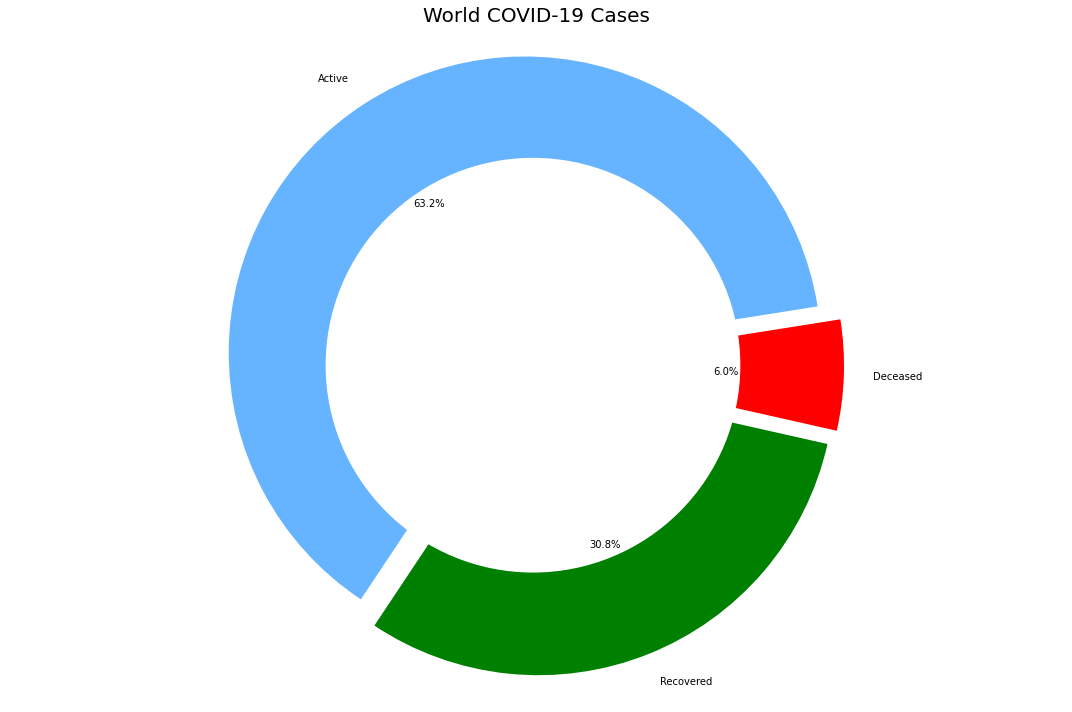

In [2]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered - world_deaths)

labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()


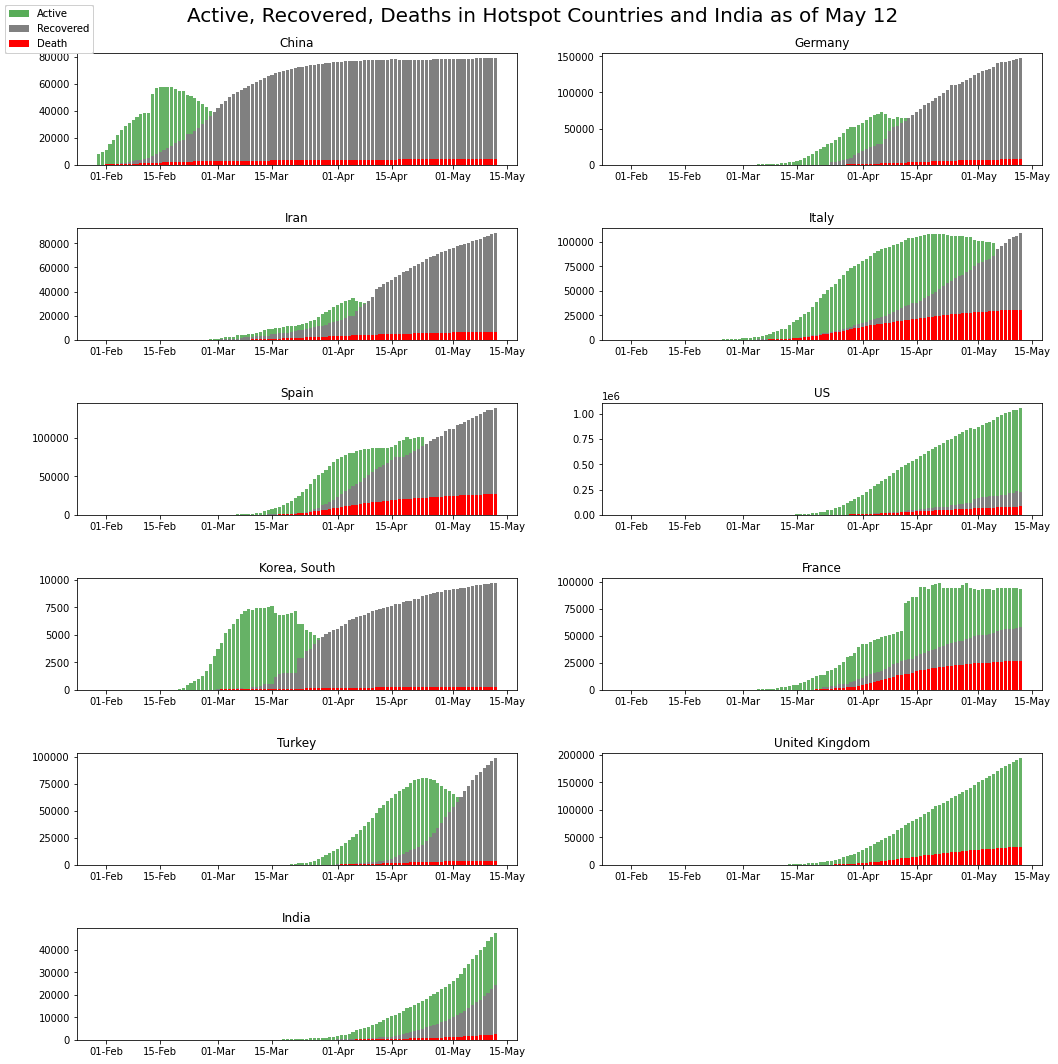

In [3]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of May 12',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)

### Certain Recovery : South Korea, Germany, Iran (Flattened the Curve!)
### Uncertain Recovery : Italy, France, Spain (Flattening!)
### United Kingdom showing very few recoveries

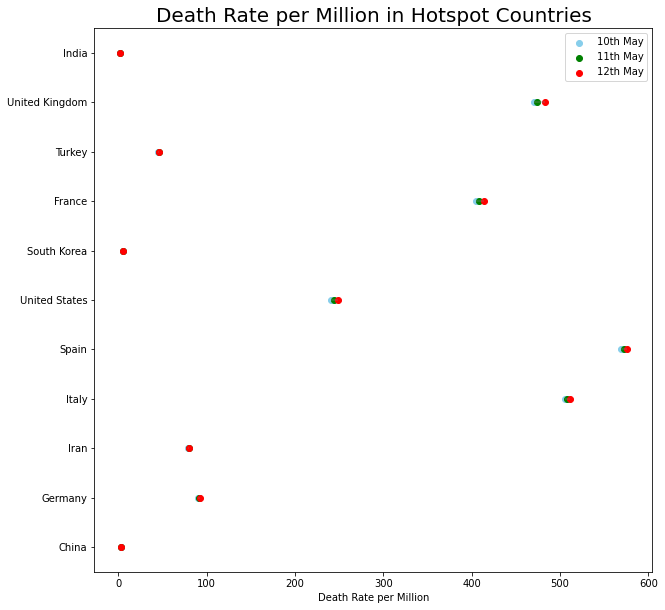

In [4]:
hotspots = ['China','Germany','Iran','Italy','Spain','United States','South Korea','France','Turkey','United Kingdom','India']
country_death_rate = pd.DataFrame(columns = ['country','day1','day2','day3'])
world_population['Population (2020)'] = world_population['Population (2020)']/1000000

d1=[]
d2 =[]
d3 = []
for country in hotspots:
    p = float(world_population[world_population['Country (or dependency)'] == country ]['Population (2020)'])
    if country == 'United States':
        k = global_deaths['US'][-3:]
    elif country == 'South Korea':
        k = global_deaths['Korea, South'][-3:]
    else:
        k = global_deaths[country][-3:]
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))

country_death_rate['country'] = hotspots
country_death_rate['day1'] = d1
country_death_rate['day2'] = d2
country_death_rate['day3'] = d3    

plt.figure(figsize= (10,10))
plt.hlines(y=country_death_rate['country'], xmin=country_death_rate['day1'], xmax=country_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(country_death_rate['day1'], country_death_rate['country'], color='skyblue', label='10th May');
plt.scatter(country_death_rate['day2'], country_death_rate['country'], color='green', label='11th May');
plt.scatter(country_death_rate['day3'], country_death_rate['country'], color='red', label='12th May');
plt.legend();
plt.title("Death Rate per Million in Hotspot Countries",fontsize=20);
plt.xlabel('Death Rate per Million');


# India Updates <a id="1"></a>

### Age Group Analysis <a id="2"></a>

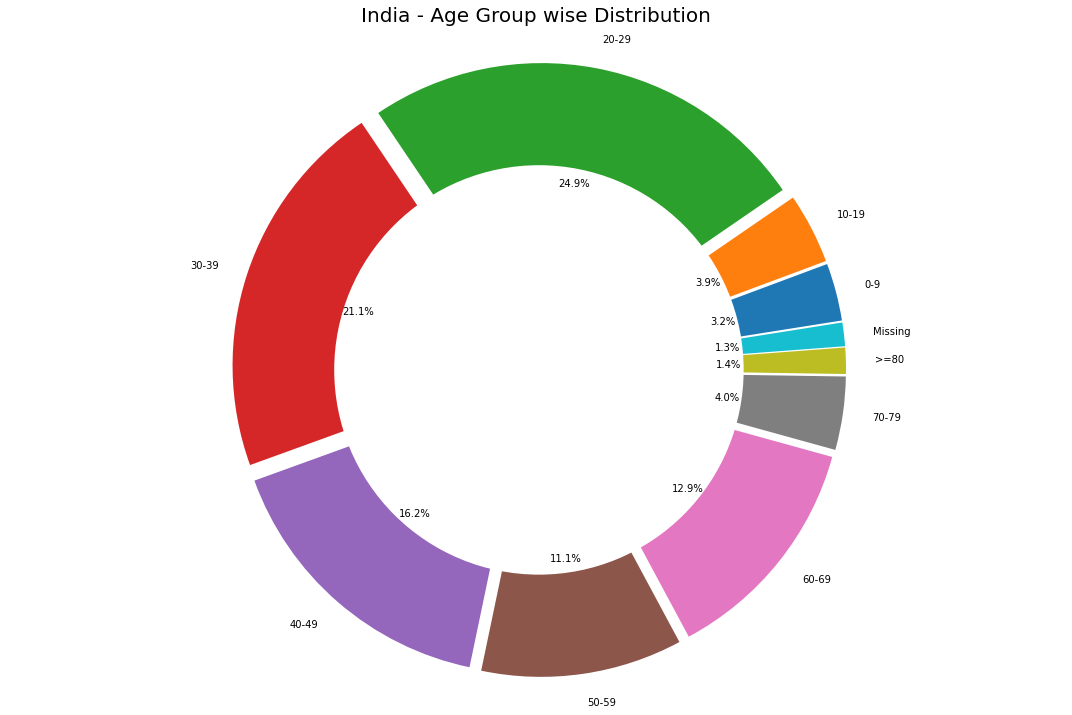

In [5]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

We could see that the **age group <40 is the most affected** which is against the trend which says elderly people are more at risk of being affected. Only 17% of people >60 are affected.

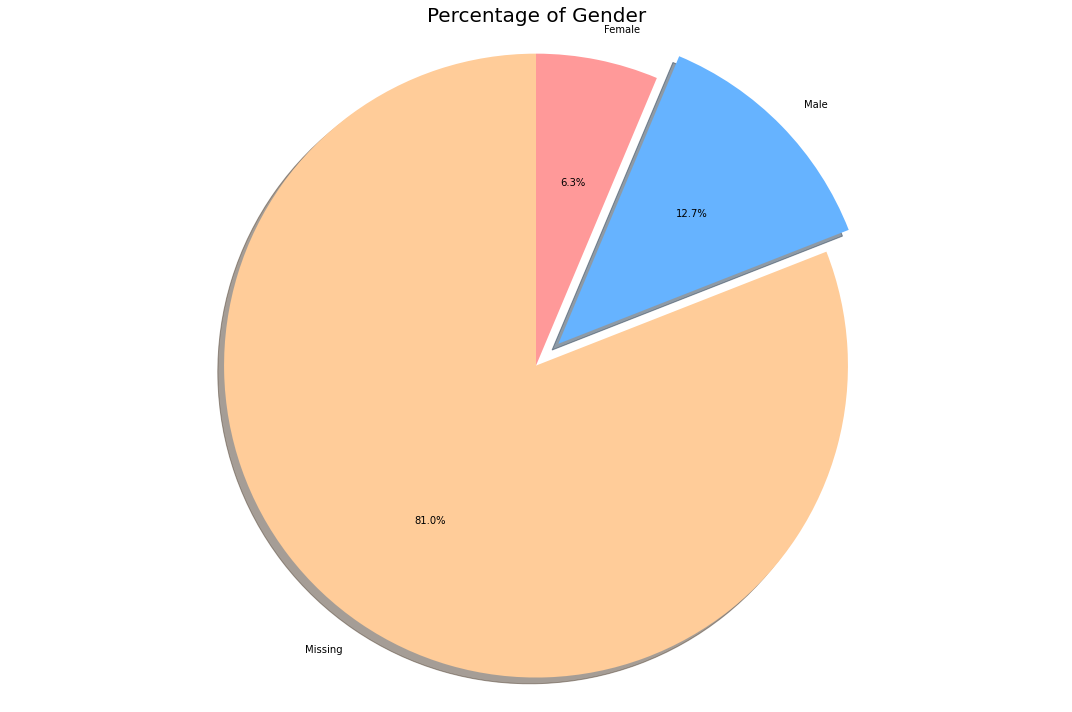

In [6]:
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

**80% of the patients gender information is missing. Let's analyse with remaining the data.

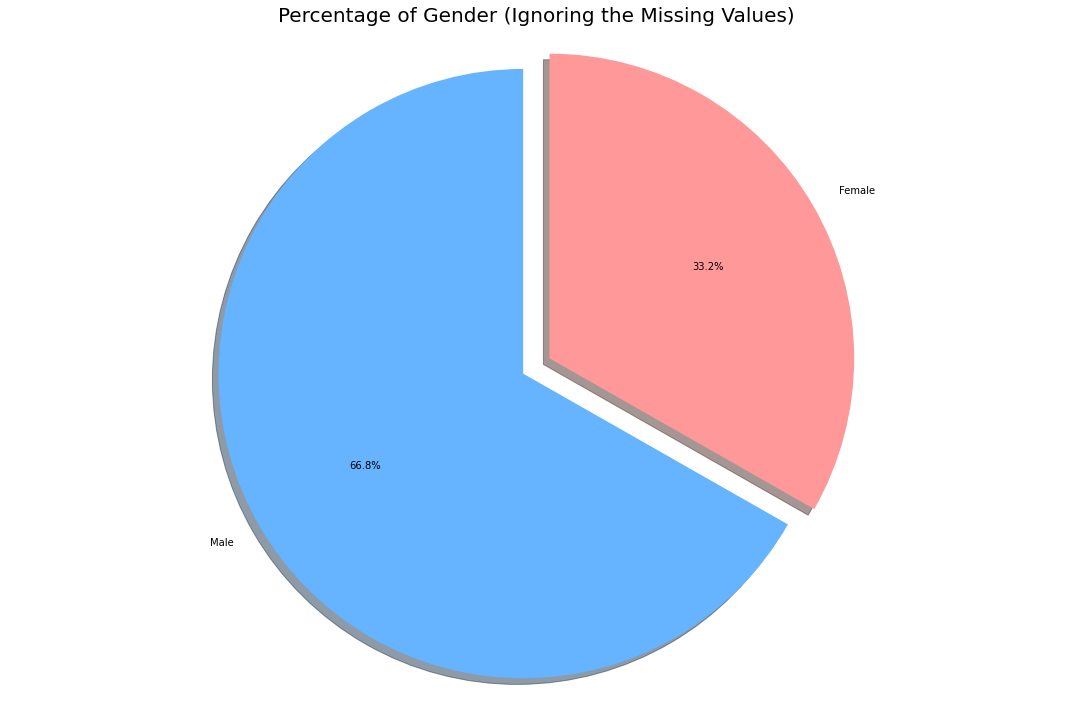

In [7]:
labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 20)
plt.axis('equal')
plt.tight_layout()

Men are the most affected accounting to 67%. But, remember we have ~80% data missing.

### The Spike in India <a id="3"></a>

In [8]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

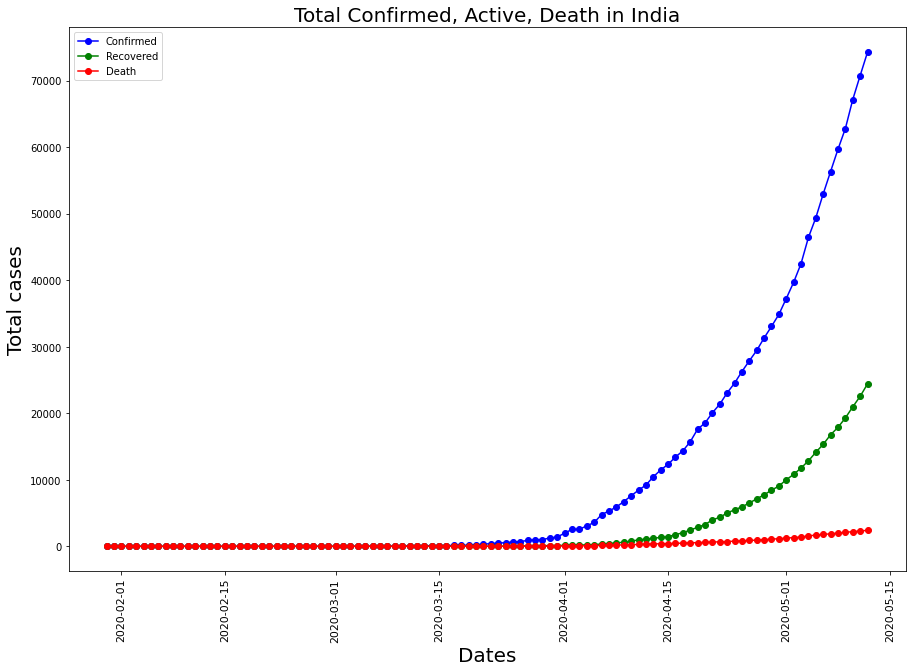

In [9]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

![](https://pbs.twimg.com/media/EX3pu-9X0AMVTsp?format=jpg&name=large)

![](https://pbs.twimg.com/media/EX3pxxcXQAI8FoE?format=jpg&name=large)
Credits : Prof. Shamika Ravi

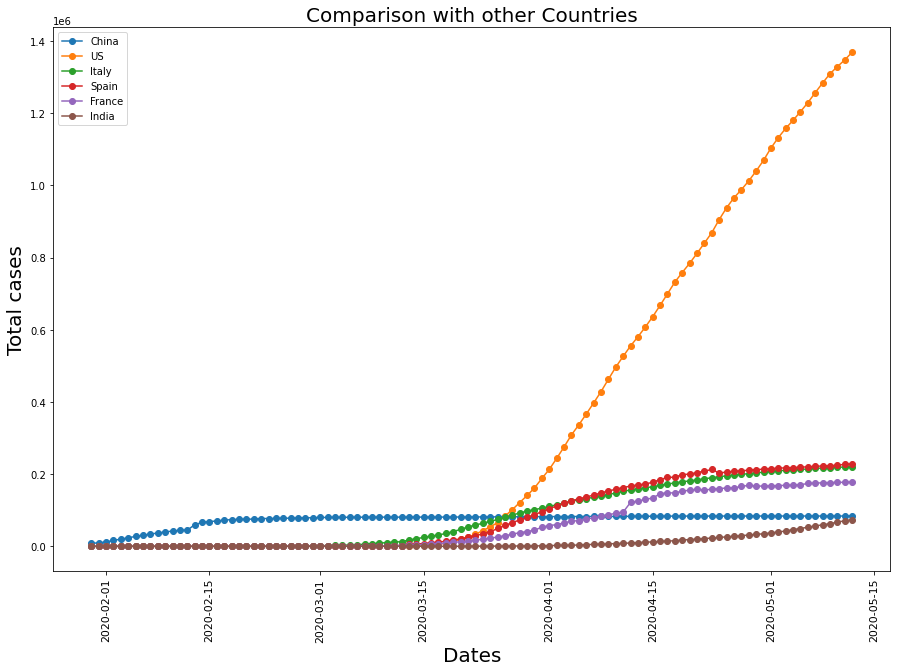

In [10]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

![](https://github.com/nitishabharathi/analysis-images/blob/master/covid%20timeline.png?raw=true)

### Though being highly populated the relative confimred cases of India is low compared to other countries. This could be because of two reasons
1. 21 day lockdown imposed by prime minister Narendra Modi (Source : [Health Ministry](http://www.indiatoday.in/india/story/without-lockdown-india-would-have-2-lakh-covid-19-cases-by-now-health-ministry-1665903-2020-04-11))
2. Low testing rate (Source: [news18](https://www.news18.com/news/india/with-just-18-tests-per-million-of-population-why-indias-low-testing-rate-for-coronavirus-is-worrying-2552845.html))

## Without lockdown, India would have 2 lakh Covid-19 cases by now: Health ministry

![](https://pbs.twimg.com/media/EVUWy8vUMAUoHEh?format=png&name=small)

### Here is another pretty good plot on health faicilities in various countries <a id="8"></a>

![](https://images.assettype.com/bloombergquint%2F2020-03%2F71e05b2a-15cc-4930-83b9-be22357e2093%2FHealthcare_Is_Less_Abundant_In_India_Compared_To_Global_Average.png?auto=format&q=35&w=1200&h=979)

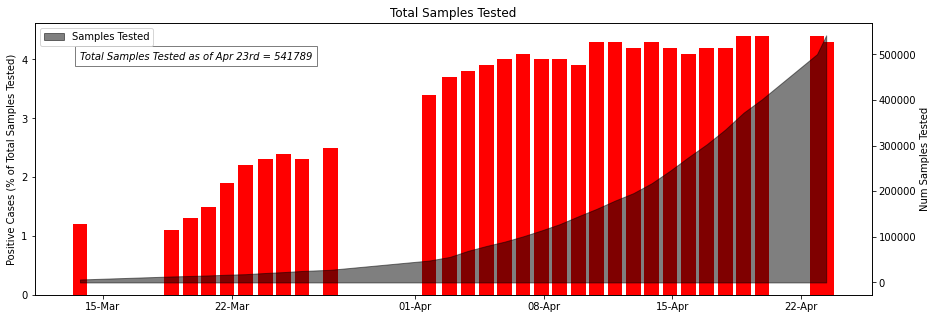

In [11]:
ICMR_details['Percent_positive'] = round((ICMR_details['TotalPositiveCases']/ICMR_details['TotalSamplesTested'])*100,1)

fig, ax1 = plt.subplots(figsize= (15,5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax1.set_ylabel('Positive Cases (% of Total Samples Tested)')
ax1.bar(ICMR_details['DateTime'] , ICMR_details['Percent_positive'], color="red",label = 'Percentage of Positive Cases')
ax1.text(ICMR_details['DateTime'][0],4, 'Total Samples Tested as of Apr 23rd = 541789', style='italic',fontsize= 10,
        bbox={'facecolor': 'white' ,'alpha': 0.5, 'pad': 5})

ax2 = ax1.twinx()  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.set_ylabel('Num Samples Tested')
ax2.fill_between(ICMR_details['DateTime'],ICMR_details['TotalSamplesTested'],color = 'black',alpha = 0.5,label = 'Samples Tested');

plt.legend(loc="upper left")
plt.title('Total Samples Tested')
plt.show()

## Statewise Insights <a id="5"></a>

In [12]:
state_cases = india_covid_19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()

#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
20,Maharashtra,24427,921,5125,18381,3.77,20.98
10,Gujarat,8903,537,3246,5120,6.03,36.46
30,Tamil Nadu,8718,61,2134,6523,0.7,24.48
8,Delhi,7639,86,2512,5041,1.13,32.88
29,Rajasthan,4126,117,2378,1631,2.84,57.63
19,Madhya Pradesh,3986,225,1860,1901,5.64,46.66
34,Uttar Pradesh,3664,82,1873,1709,2.24,51.12
36,West Bengal,2173,198,612,1363,9.11,28.16
1,Andhra Pradesh,2090,46,1056,988,2.2,50.53
28,Punjab,1914,32,171,1711,1.67,8.93


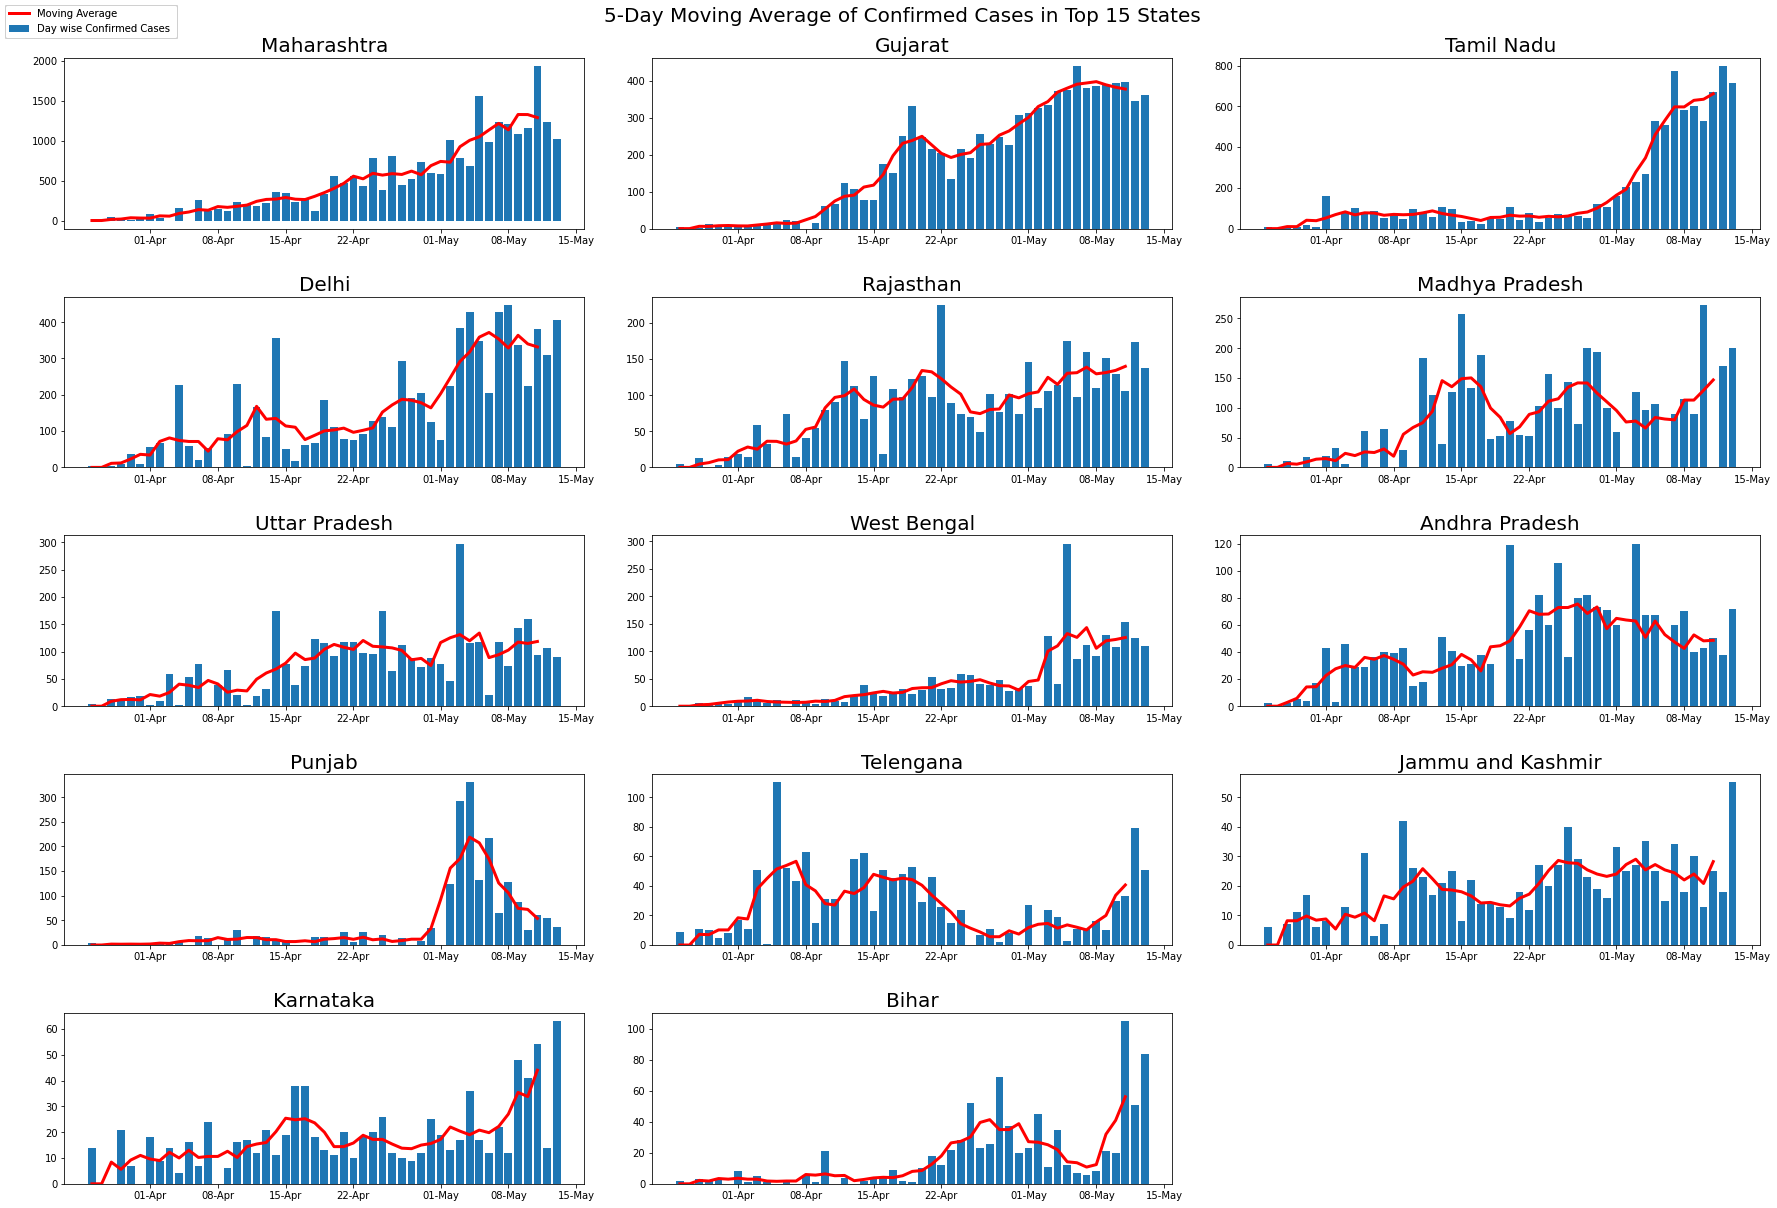

In [13]:
all_state = list(india_covid_19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
#all_state.remove('Nagaland#')
#all_state.remove('Nagaland')
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
def calc_movingaverage(values ,N):    
    cumsum, moving_aves = [0], [0,0]
    for i, x in enumerate(values, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves

fig = plt.figure(figsize= (25,17))
plt.suptitle('5-Day Moving Average of Confirmed Cases in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    moving_aves = calc_movingaverage(states_confirmed[states[k]],5)
    ax.plot(states_dates[states[k]][:-2],moving_aves,color='red',label = 'Moving Average',linewidth =3)  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

### Big Increases: Rajasthan, TN, Gujarat, WB, UP, Punjab, Maharashtra

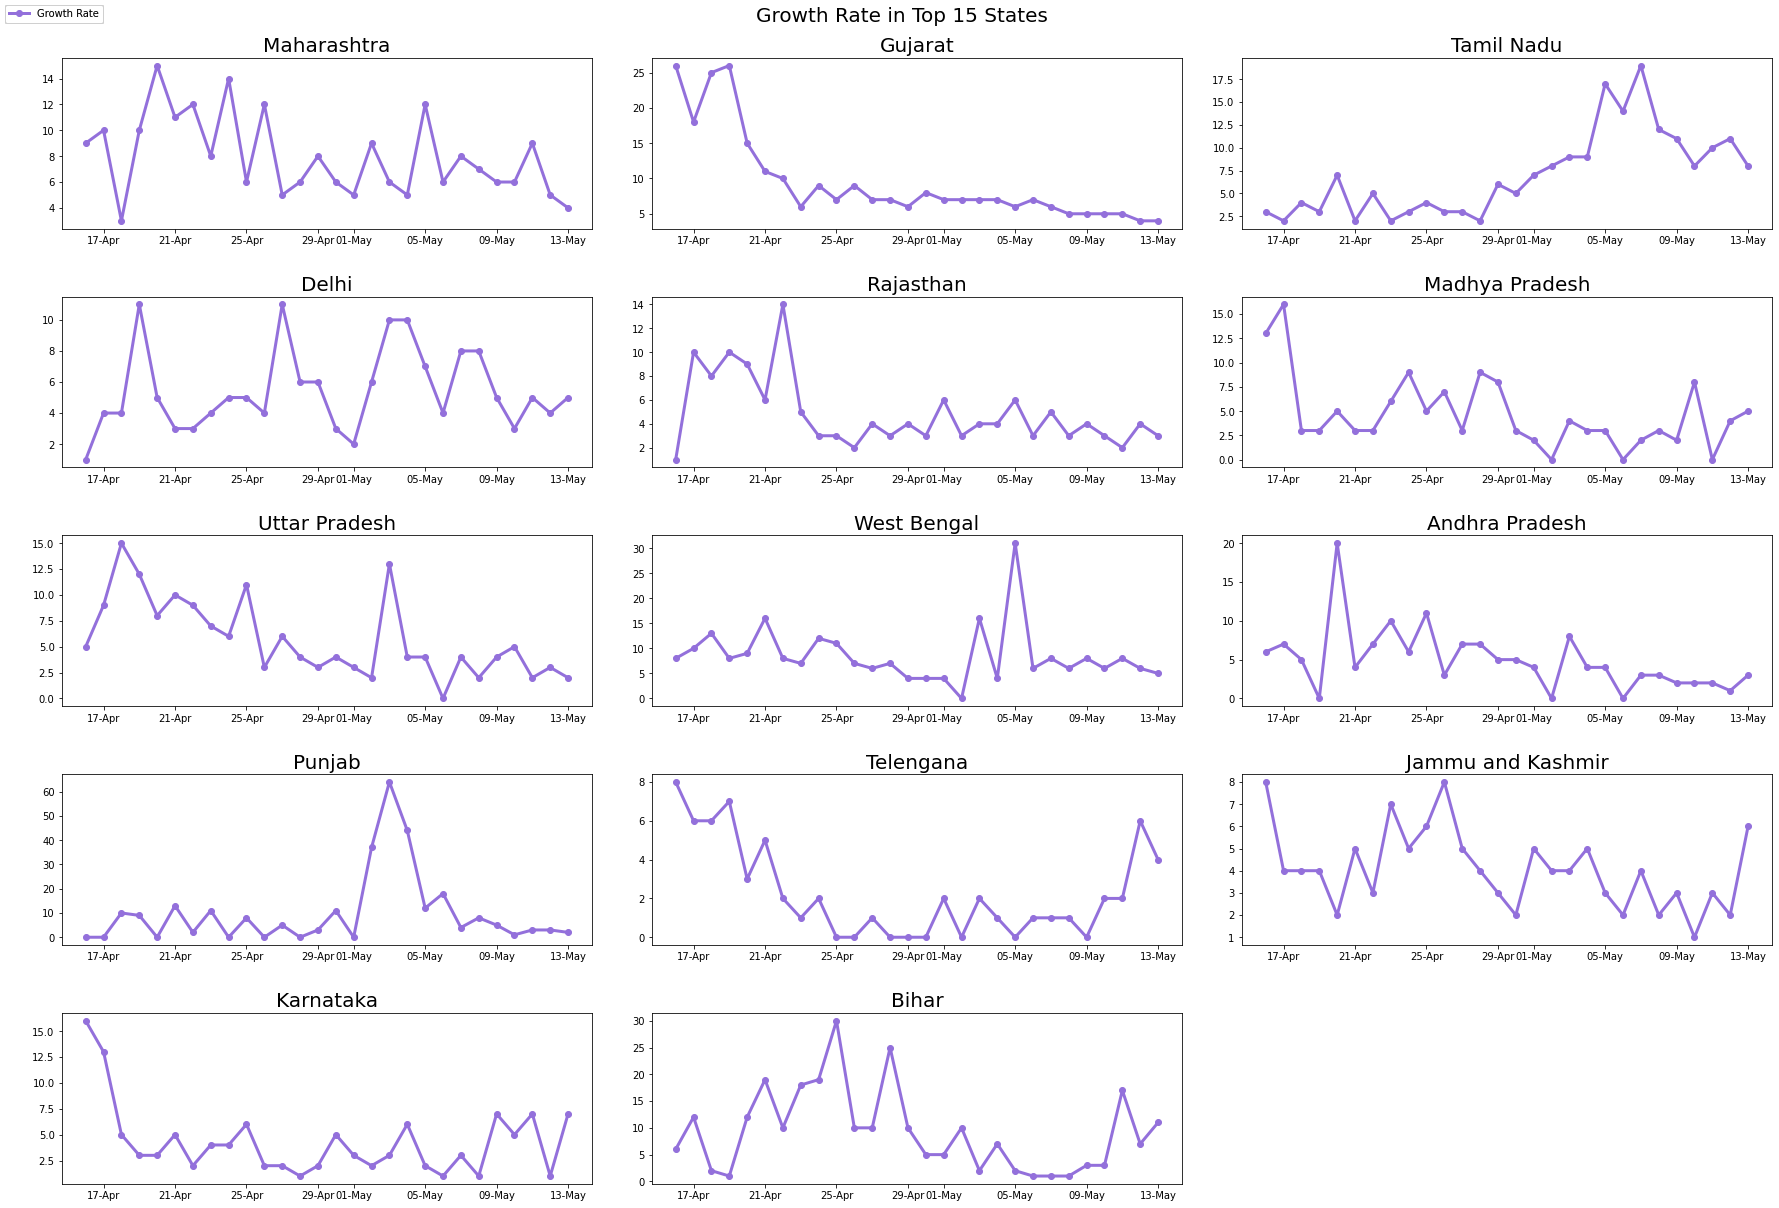

In [14]:
def calc_growthRate(values):
    k = []
    for i in range(1,len(values)):
        summ = 0
        for j in range(i):
            summ = summ + values[j]
        rate = (values[i]/summ)*100
        k.append(int(rate))
    return k

fig = plt.figure(figsize= (25,17))
plt.suptitle('Growth Rate in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    #ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    growth_rate = calc_growthRate(states_confirmed[states[k]])
    ax.plot_date(states_dates[states[k]][21:],growth_rate[20:],color = '#9370db',label = 'Growth Rate',linewidth =3,linestyle='-')  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

In [15]:
#norm = matplotlib.colors.Normalize(vmin=min(state_cases.Confirmed), vmax=max(state_cases.Confirmed))
#colors = [matplotlib.cm.Blues(norm(value)) for value in state_cases.Confirmed]

#plt.figure(figsize= (15,10))
#fig = plt.gcf()
#ax = fig.add_subplot()

#squarify.plot(label=list(state_cases.index),sizes=state_cases.Confirmed, color = colors, alpha=.6)

#plt.title("Statewise Distribution",fontsize=23,fontweight="bold")
#plt.axis('off')
#plt.show()

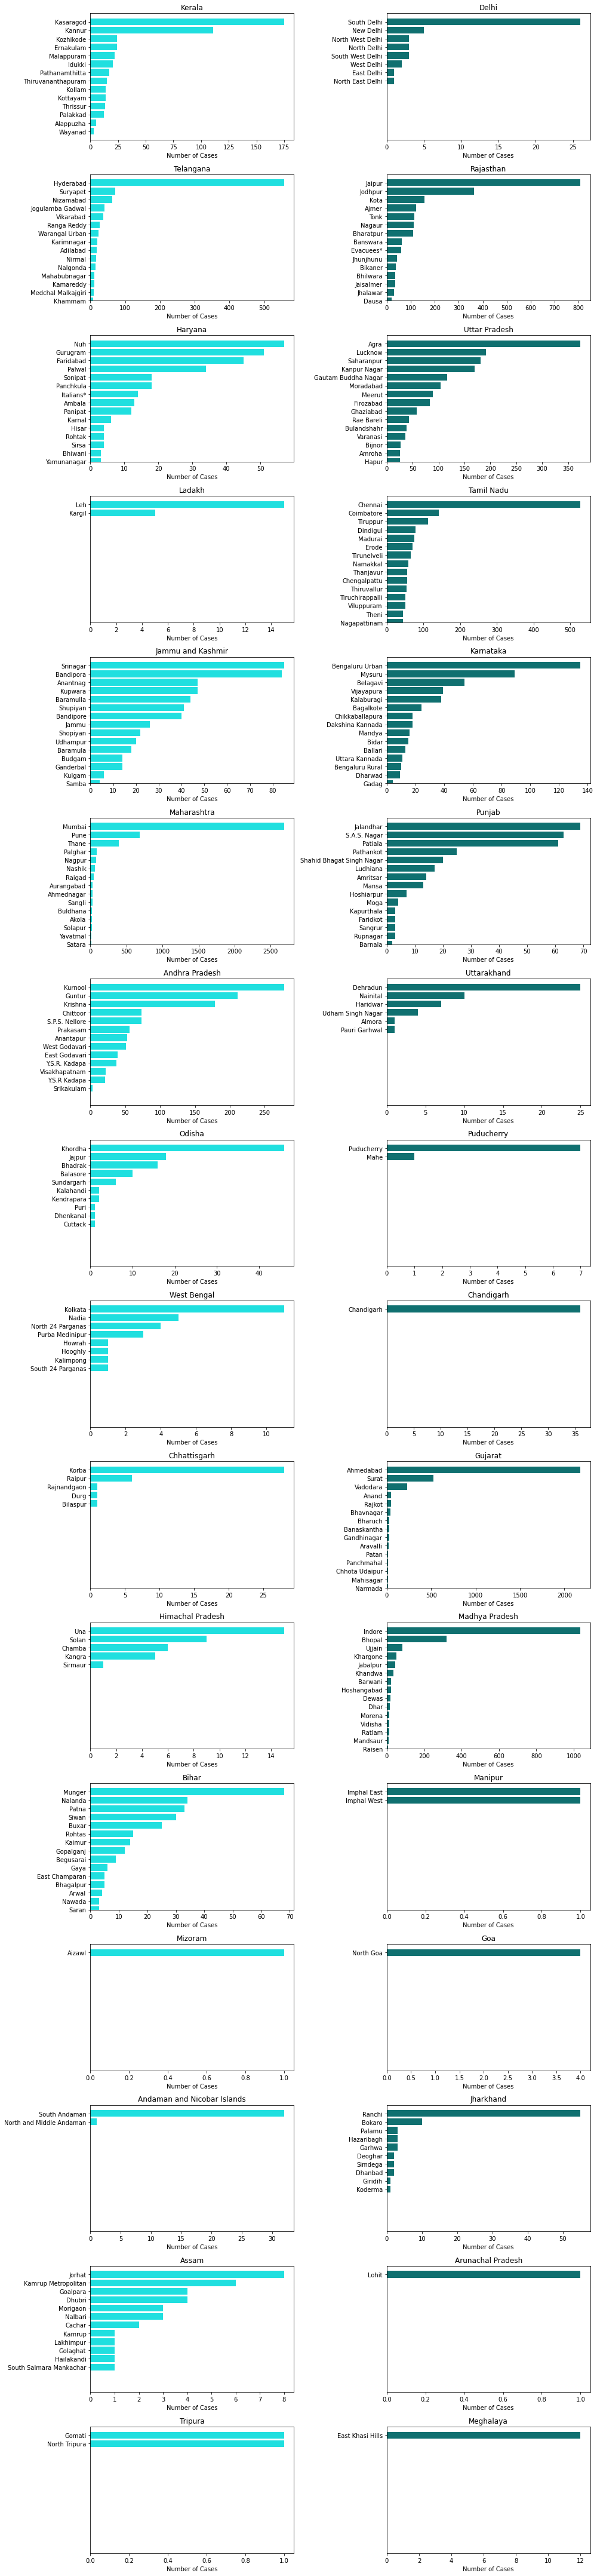

In [16]:
colors_list = ['cyan','teal']
states = individual_details['detected_state'].unique()
if len(states)%2==0:
    n_rows = int(len(states)/2)
else:
    n_rows = int((len(states)+1)/2)    
plt.figure(figsize=(14,60))

for idx,state in enumerate(states):    
    plt.subplot(n_rows,2,idx+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    try:
        g = sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',orient='v',color=colors_list[idx%2],order=y_order)
        plt.xlabel('Number of Cases')
        plt.ylabel('')
        plt.title(state)
        plt.ylim(14,-1)
    except:
        pass
plt.tight_layout()
plt.show()

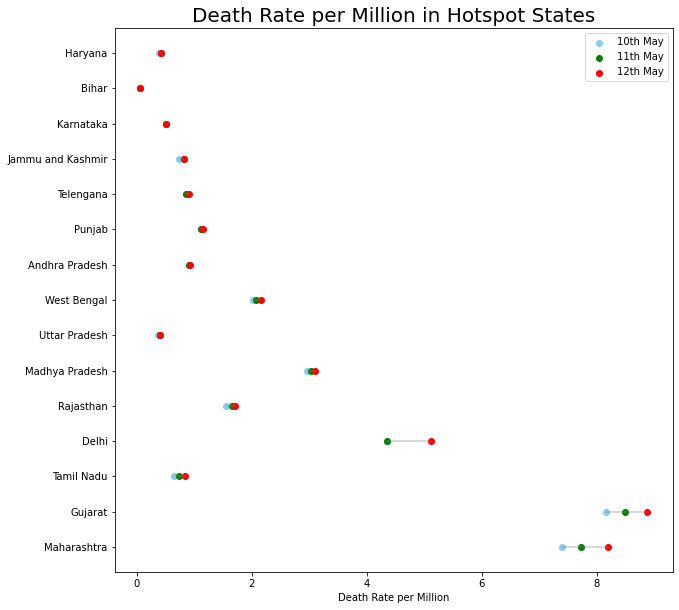

In [17]:
population['in_million'] = population['Population']/1000000
state_death_rate = pd.DataFrame(columns = ['state','day1','day2','day3'])
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

s = []
d1 = []
d2 = []
d3 = []

for state in states:
    k = list(india_covid_19[india_covid_19['State/UnionTerritory'] == state]['Deaths'].tail(3))
    p = float(population[population['State / Union Territory']== state]['in_million'])
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))
    s.append(state)
    
state_death_rate['state'] = s
state_death_rate['day1'] = d1
state_death_rate['day2'] = d2
state_death_rate['day3'] = d3

plt.figure(figsize= (10,10))
plt.hlines(y=state_death_rate['state'], xmin=state_death_rate['day1'], xmax=state_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(state_death_rate['day1'], state_death_rate['state'], color='skyblue', label='10th May');
plt.scatter(state_death_rate['day2'], state_death_rate['state'], color='green', label='11th May');
plt.scatter(state_death_rate['day3'], state_death_rate['state'], color='red', label='12th May');
plt.legend();
plt.title("Death Rate per Million in Hotspot States",fontsize=20);
plt.xlabel('Death Rate per Million');

### Statewise Testing and Healthcare Insights <a id="6"></a>

In [18]:
hospital_beds =hospital_beds.drop([36])
cols_object = list(hospital_beds.columns[2:8])

for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors = 'ignore')

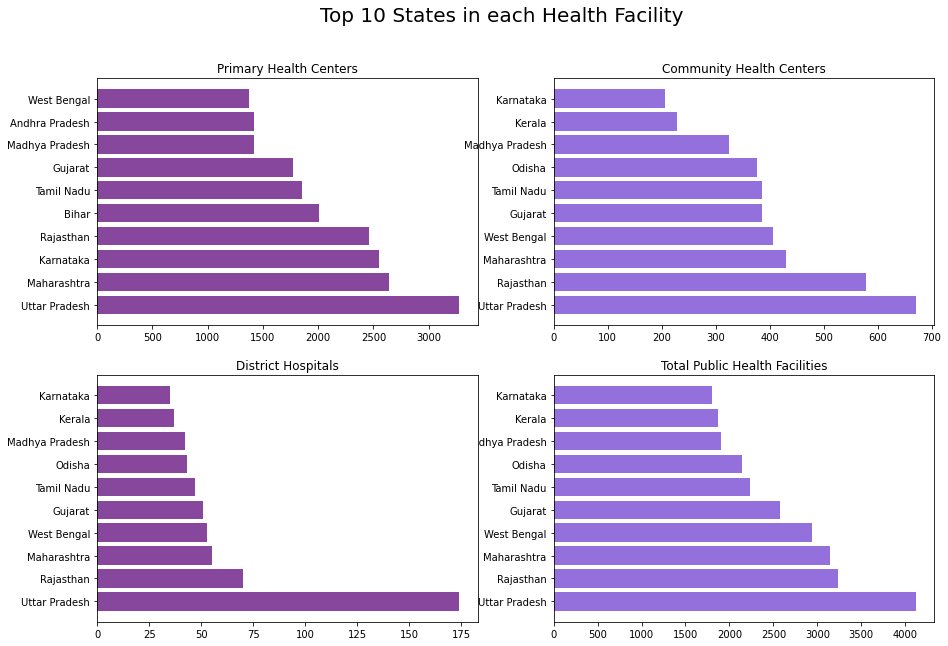

In [19]:
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

plt.figure(figsize=(15,10))
plt.suptitle('Top 10 States in each Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='#87479d');

plt.subplot(222)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db');

plt.subplot(224)
plt.title('Total Public Health Facilities')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db');

plt.subplot(223)
plt.title('District Hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = '#87479d');

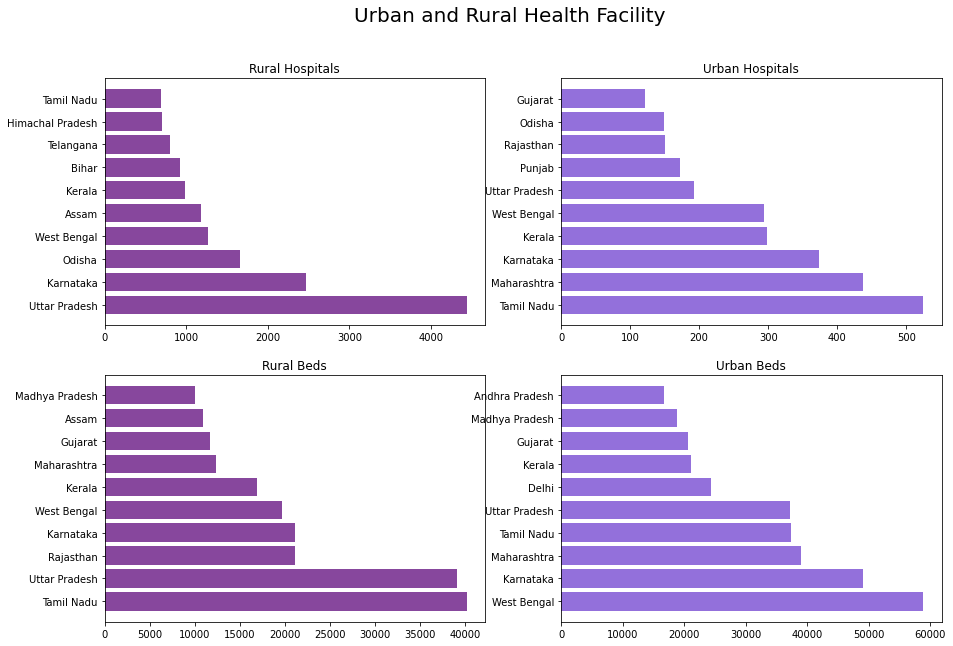

In [20]:
top_rural_hos = hospital_beds.nlargest(10,'NumRuralHospitals_NHP18')
top_rural_beds = hospital_beds.nlargest(10,'NumRuralBeds_NHP18')
top_urban_hos = hospital_beds.nlargest(10,'NumUrbanHospitals_NHP18')
top_urban_beds = hospital_beds.nlargest(10,'NumUrbanBeds_NHP18')

plt.figure(figsize=(15,10))
plt.suptitle('Urban and Rural Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Rural Hospitals')
plt.barh(top_rural_hos['State/UT'],top_rural_hos['NumRuralHospitals_NHP18'],color = '#87479d');

plt.subplot(222)
plt.title('Urban Hospitals')
plt.barh(top_urban_hos['State/UT'],top_urban_hos['NumUrbanHospitals_NHP18'],color = '#9370db');

plt.subplot(223)
plt.title('Rural Beds')
plt.barh(top_rural_beds['State/UT'],top_rural_beds['NumRuralBeds_NHP18'],color = '#87479d');

plt.subplot(224)
plt.title('Urban Beds')
plt.barh(top_urban_beds['State/UT'],top_urban_beds['NumUrbanBeds_NHP18'],color = '#9370db');

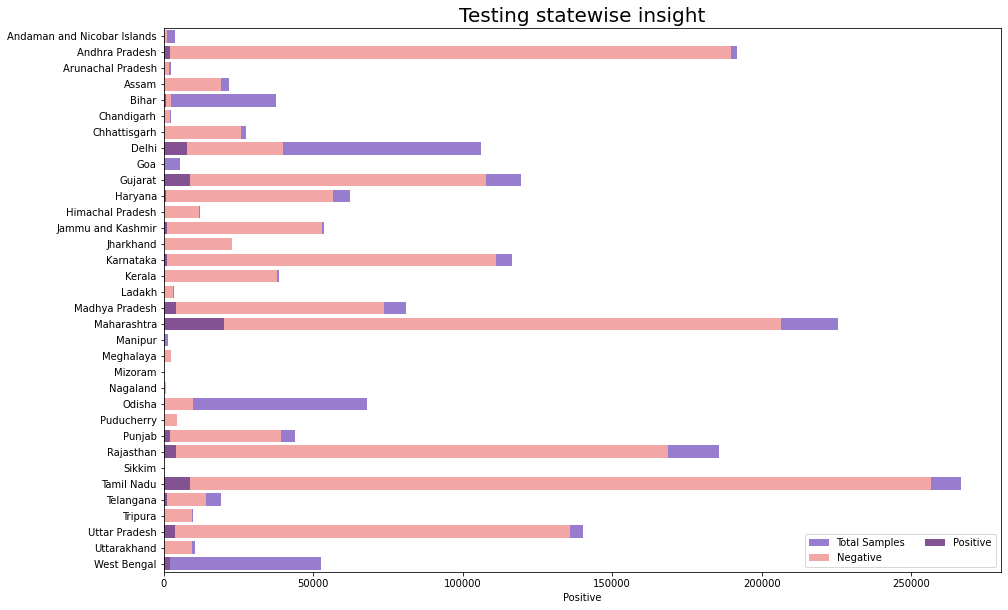

In [21]:
state_test = pd.pivot_table(state_testing, values=['TotalSamples','Negative','Positive'], index='State', aggfunc='max')
state_names = list(state_test.index)
state_test['State'] = state_names

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = '#9370db')
sns.barplot(x='Negative', y=state_names, data=state_test,label='Negative', color= '#ff9999')
sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='#87479d')
plt.title('Testing statewise insight',fontsize = 20)
plt.legend(ncol=2, loc="lower right", frameon=True);

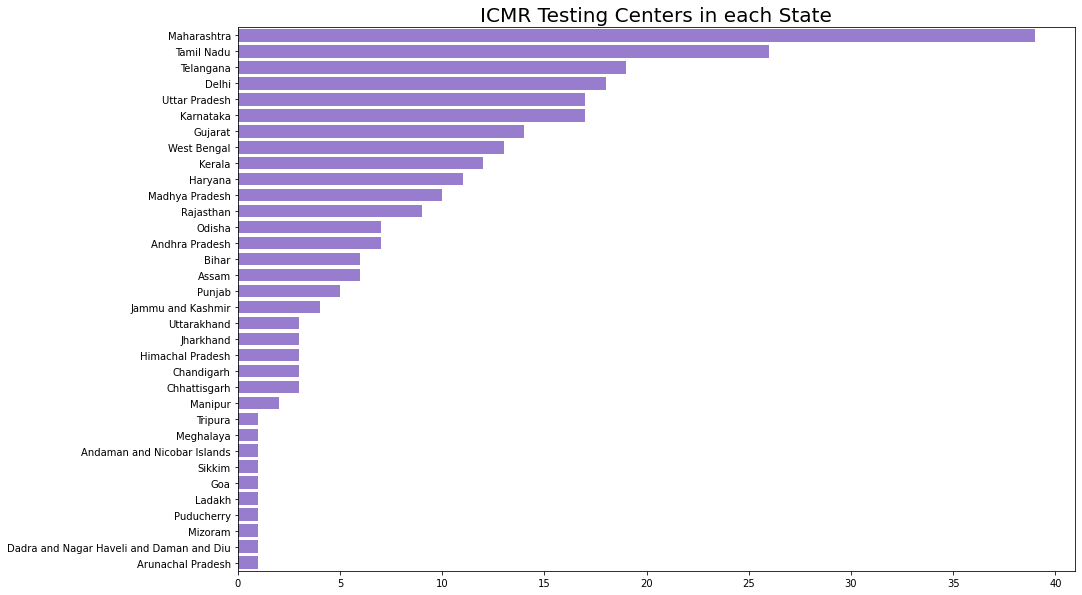

In [22]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#9370db');

## Economic Impact of COVID-19 on India <a id="4"></a>

### The coronavirus is having a growing impact on the Indian economy. Here is an interesting insight on how an extenstion of the lockdown would affect the economy (Credits: McKincy & Company)

![](https://www.mckinsey.com/~/media/McKinsey/Featured%20Insights/India/Getting%20ahead%20of%20coronavirus%20Saving%20lives%20and%20livelihoods%20in%20India/SVGZ-India-COVID-ex1.ashx)

# Prediction <a id="7"></a>

## Prediction using growth factor <a id="9"></a>
#### Assuming the same growth factor continues for the next 15 days

In [23]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.141062628486886


#### Prediction for the next 15 days

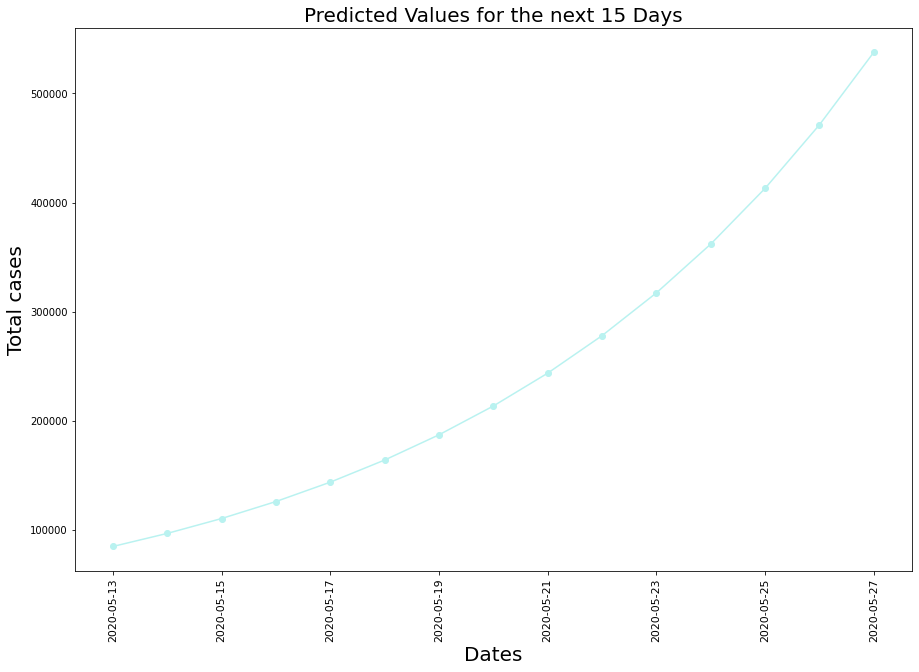

In [24]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')

We could see that the graph is increasing exponentialy if the average growth factor doesn't decrease. It is important that the growth factor is reduced to flatten the curve.

In [25]:
train = pd.read_csv('../input/covid19-global-forecasting-week-4/train.csv')
test = pd.read_csv('../input/covid19-global-forecasting-week-4/test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

## Prediction using Prophet Model <a id="10"></a>

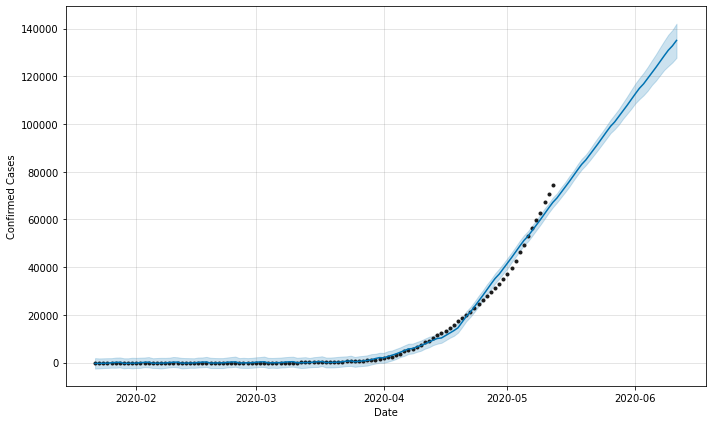

In [26]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

## Prediction using ARIMA <a id="11"></a>

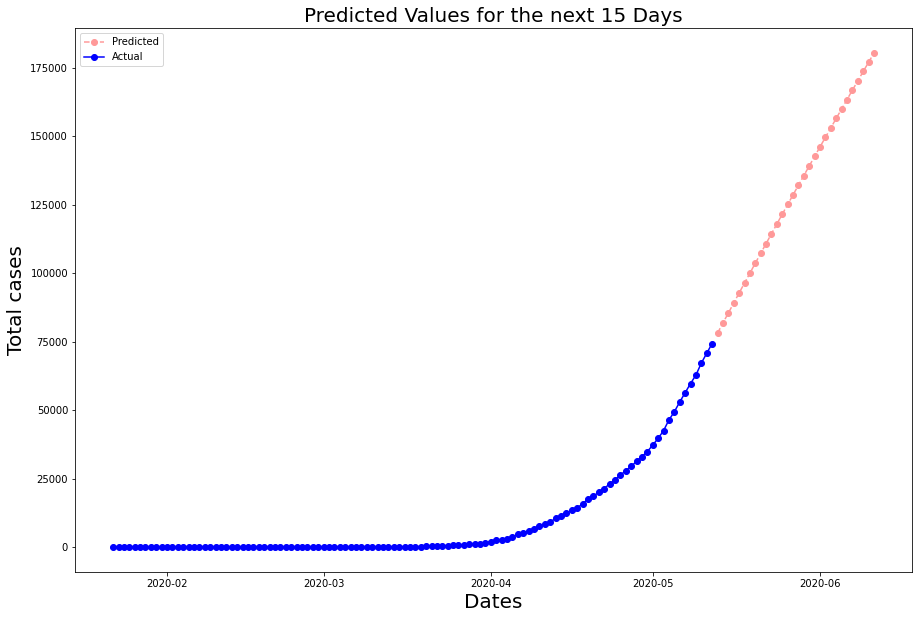

In [27]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [28]:
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['quarter'] = train['Date'].dt.quarter
train['weekofyear'] = train['Date'].dt.weekofyear
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['quarter'] = test['Date'].dt.quarter
test['weekofyear'] = test['Date'].dt.weekofyear
countries = list(train['Country_Region'].unique())
india_code = countries.index('India')
train = train.drop(['Date','Id'],1)
test =  test.drop(['Date'],1)

train.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
train[['Province_State','Country_Region']] = oe.fit_transform(train.loc[:,['Province_State','Country_Region']])

test.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
test[['Province_State','Country_Region']] = oe.fit_transform(test.loc[:,['Province_State','Country_Region']])

In [29]:
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State','Country_Region']
train = train[columns]
x = train.drop(['Fatalities','ConfirmedCases'], 1)
y = train['ConfirmedCases']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
test = test[test_columns]
test_india = test[test['Country_Region'] == india_code]

In [30]:
models = []
mse = []
mae = []
rmse = []

## LGBM Regressor <a id="12"></a>

In [31]:
lgbm = LGBMRegressor(n_estimators=1300)
lgbm.fit(x_train,y_train)
pred = lgbm.predict(x_test)
lgbm_forecast = lgbm.predict(test_india)
models.append('LGBM')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

## Random Forest Regressor <a id="13"></a>

In [32]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
rfr_forecast = rf.predict(test_india)
models.append('Random Forest')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

## XGB Regressor<a id="14"></a>

In [33]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
xgb_forecast = xgb.predict(test_india)
models.append('XGBoost')
mse.append(round(mean_squared_error(pred, y_test),2))
mae.append(round(mean_absolute_error(pred, y_test),2))
rmse.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

# Interesting Insights for the Day from other Sources <a id="25"></a>
## <font color='purple'>1. Decline in Doubling Rate</font>
![](https://github.com/nitishabharathi/analysis-images/blob/master/doubling%20rate.JPG?raw=true)

Red dot -> Doubling Rate as of May 4
Grey dot -> Doubling Rate as of May 5
## TN, Haryana, Punjab - Doubling Rate decreased. This implies a sharp rise in infections in these states.
(Credits: The Hindu)


## <font color='purple'>2. The Kasaragod Model (Kasaragod is the northenmost district of Kerala)</font>
![](https://pbs.twimg.com/media/EWCu2VKXgAA-55I?format=jpg&name=large)
(Credits: Prof Shamika Ravi, The Indian Express)
### Kasaragod reported the third case of COVID-19 in the country - a student airlifted from Wuhan on Feb 3. The district administration mounted a massive exercise to trace the 150 contacts of that one student. Kararagod has had 169 cases and zero deaths until April 19, a unique achievement. 

## 3. <font color='purple'>Projected vs Actual Cases!</font>
![](https://pbs.twimg.com/media/EWl_4nTXkAAyNGg?format=jpg&name=large)

#                  Stay home! Stay Safe!

### For detailed analysis on the recent oil price fall checkout my notebook [The Shrinkage of Crude Oil Price](https://www.kaggle.com/nitishabharathi/the-shrinkage-of-crude-oil-price)